<a href="https://colab.research.google.com/github/alexkrisk/Group_project/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B8_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

Загрузка данных

In [ ]:
coffee = pd.read_excel('coffee_shop_clean.xlsx')
coffee.head()

,quantity,unit_price,product_name,product_category,store_city,gender,age
0,1,2925.0,Civet Cat,Coffee beans,Санкт-Петербург,мужской,53
1,1,2925.0,Civet Cat,Coffee beans,Санкт-Петербург,мужской,68
2,1,2925.0,Civet Cat,Coffee beans,Санкт-Петербург,женский,30
3,1,2925.0,Civet Cat,Coffee beans,Москва,мужской,54
4,1,2925.0,Civet Cat,Coffee beans,Москва,женский,39


Структура данных

In [ ]:
coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17649 entries, 0 to 17648
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   quantity          17649 non-null  int64  
 1   unit_price        17649 non-null  float64
 2   product_name      17649 non-null  object 
 3   product_category  17649 non-null  object 
 4   store_city        17649 non-null  object 
 5   gender            17649 non-null  object 
 6   age               17649 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 965.3+ KB


Описательная статистика

In [ ]:
coffee.describe()

,quantity,unit_price,age
count,17649.000000,17649.000000,17649.000000
mean,1.433622,216.118463,49.819083
std,0.521983,152.954761,14.840767
min,1.000000,52.000000,24.000000
25%,1.000000,162.500000,37.000000
50%,1.000000,195.000000,50.000000
75%,2.000000,243.750000,63.000000
max,4.000000,2925.000000,75.000000


Столбец с общим доходом

In [ ]:
coffee['total_income'] = coffee['quantity'] * coffee['unit_price']

Гистограмма распределения дохода

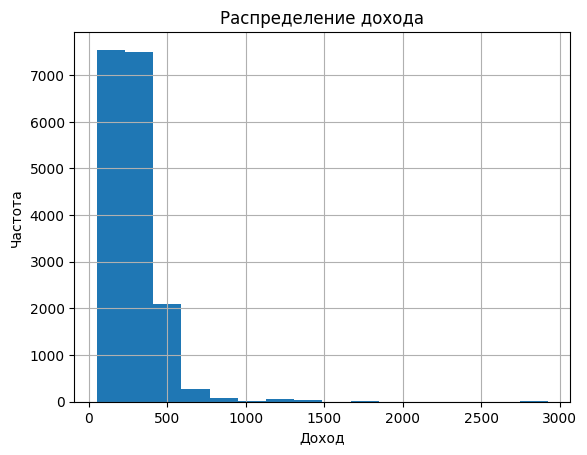

In [ ]:
coffee['total_income'].hist(bins='sturges')
plt.title('Распределение дохода')
plt.xlabel('Доход')
plt.ylabel('Частота')
plt.show()

Парные графики для распределения дохода

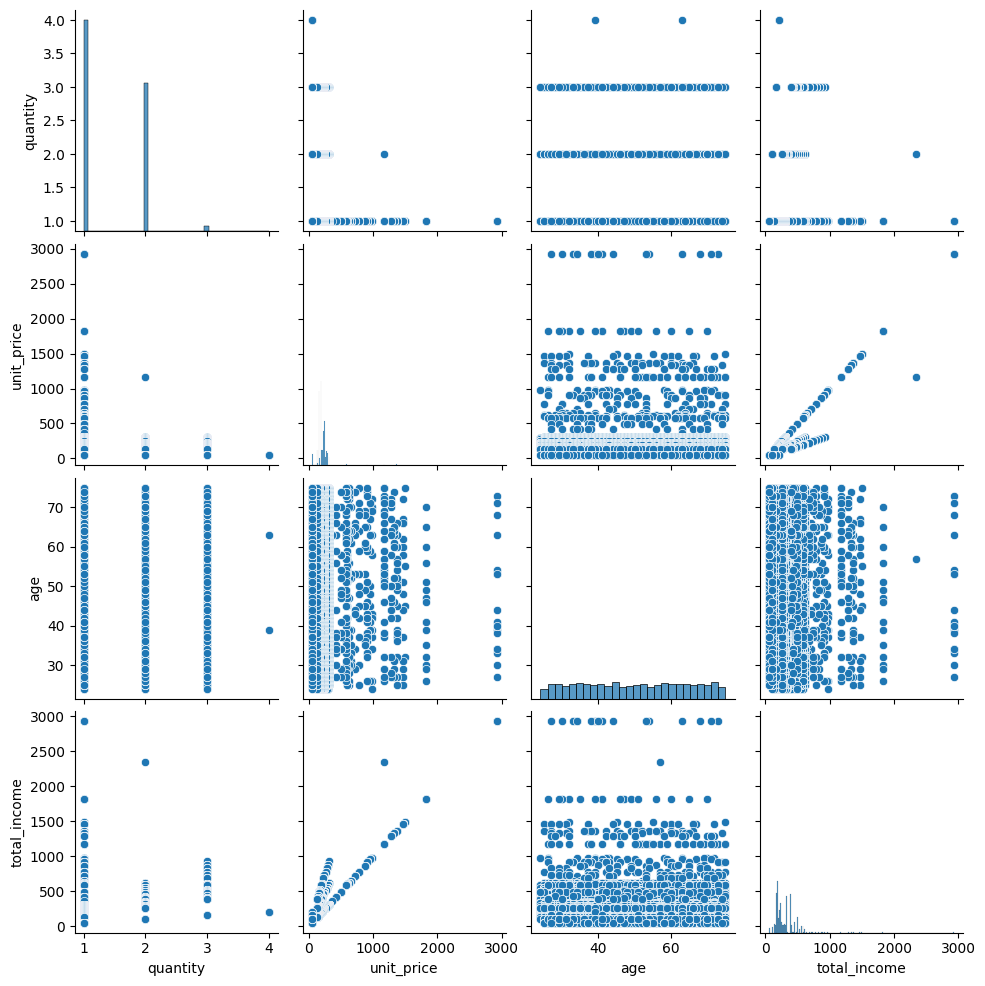

In [ ]:
numeric_cols = ['quantity', 'unit_price', 'age', 'total_income']
sns.pairplot(coffee[numeric_cols])
plt.show()

Кореляционная матрица

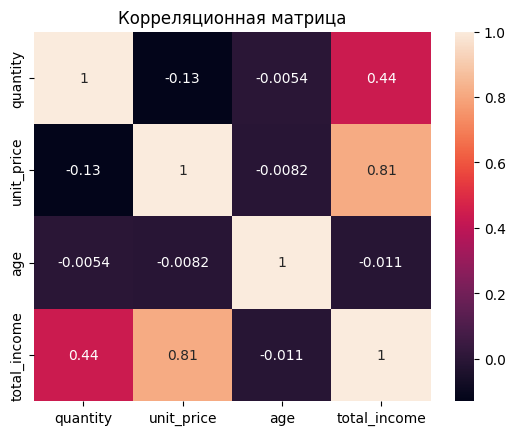

In [ ]:
corr_matrix = coffee[numeric_cols].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
plt.title('Корреляционная матрица')
plt.show()

Проверка нормальности распределения

In [ ]:
Norm = pd.DataFrame(columns=['p-value', 'Norm'], index=numeric_cols)
for c in numeric_cols:
    Norm.at[c, 'p-value'] = stats.shapiro(coffee[c])[1]
    Norm.at[c, 'Norm'] = 'Normal' if stats.shapiro(coffee[c])[1] > 0.05 else 'Unknown'
print(Norm)

             p-value     Norm
quantity         0.0  Unknown
unit_price       0.0  Unknown
age              0.0  Unknown
total_income     0.0  Unknown


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17649.
  res = hypotest_fun_out(*samples, **kwds)


Визуализация дохода по категориям товаров

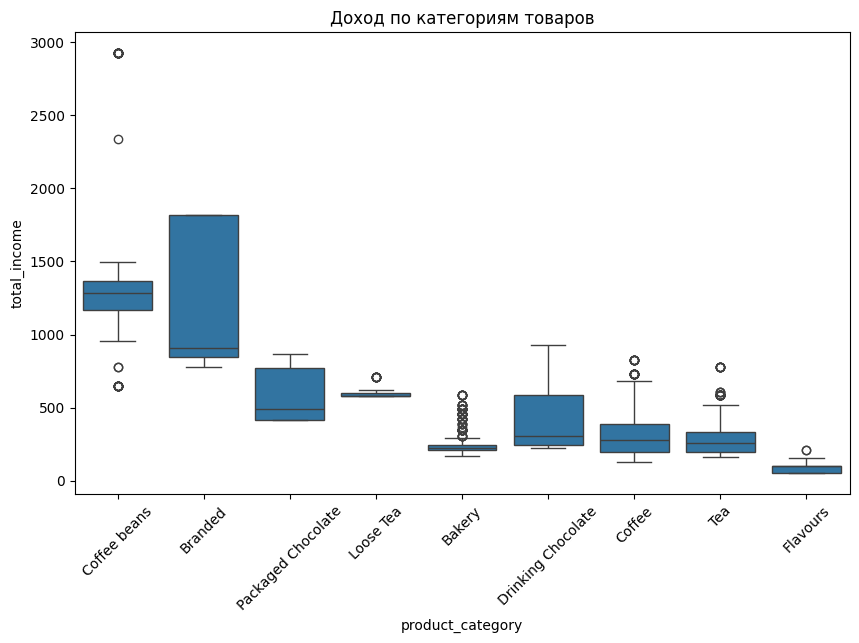

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='product_category', y='total_income', data=coffee)
plt.title('Доход по категориям товаров')
plt.xticks(rotation=45)
plt.show()

Визуализация дохода по городам

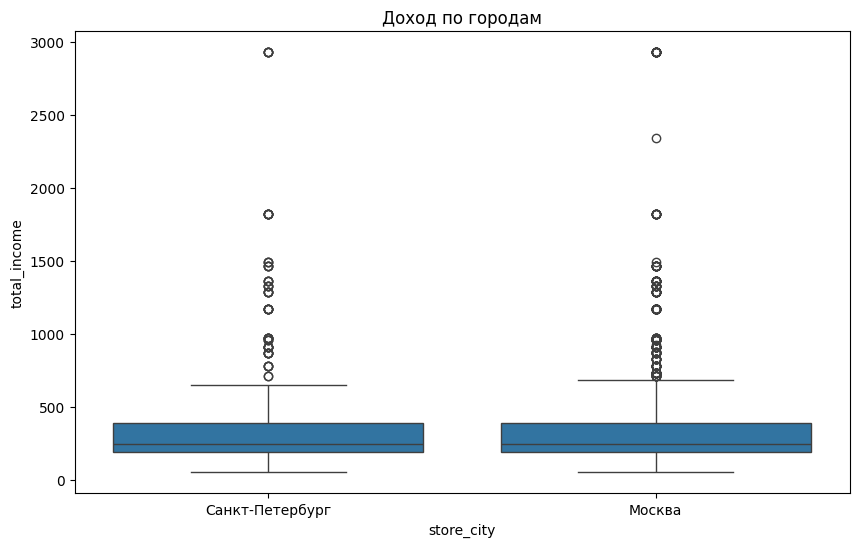

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='store_city', y='total_income', data=coffee)
plt.title('Доход по городам')
plt.show()

Визуализация дохода по полу покупателей

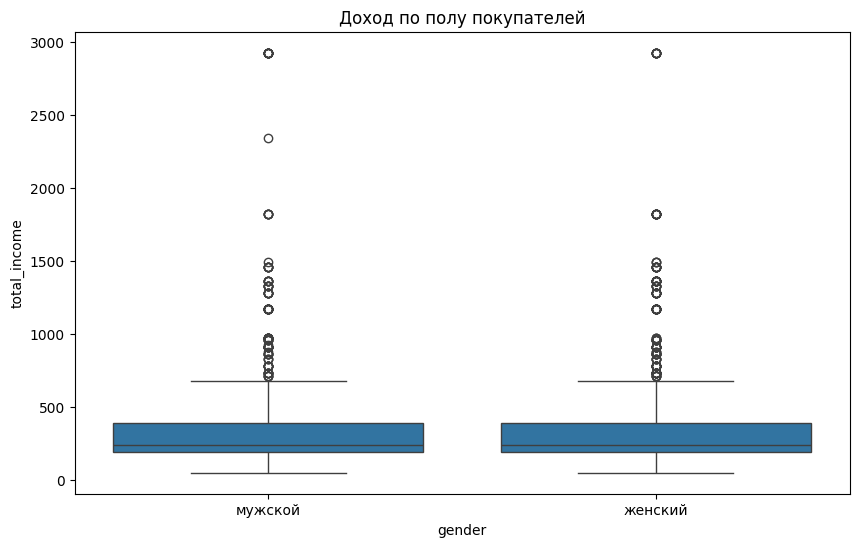

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='gender', y='total_income', data=coffee)
plt.title('Доход по полу покупателей')
plt.show()

# **Регрессионная модель**

Линейная регрессия: доход от цены за единицу

In [ ]:
results1 = smf.ols('total_income ~ unit_price', data=coffee).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:           total_income   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                 3.440e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:12:07   Log-Likelihood:            -1.0732e+05
No. Observations:               17649   AIC:                         2.146e+05
Df Residuals:                   17647   BIC:                         2.147e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     90.6371      1.379     65.714      0.0

Логарифмическая трансформация

In [ ]:
coffee['unit_price_log'] = np.log(coffee['unit_price'])
coffee['total_income_log'] = np.log(coffee['total_income'])

График после логарифмирования

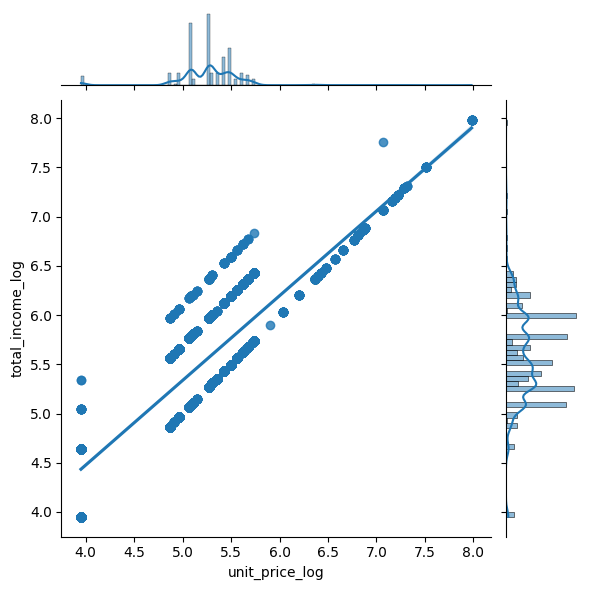

In [ ]:
sns.jointplot(x='unit_price_log', y='total_income_log', data=coffee, kind='reg')
plt.show()

Регрессия с логарифмированными переменными

In [ ]:
results2 = smf.ols('total_income_log ~ unit_price_log', data=coffee).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:       total_income_log   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 1.626e+04
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:12:16   Log-Likelihood:                -6379.3
No. Observations:               17649   AIC:                         1.276e+04
Df Residuals:                   17647   BIC:                         1.278e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0348      0.036     28.

Регрессия с категориальными переменными

In [ ]:
results3 = smf.ols('total_income_log ~ unit_price_log + product_category + store_city + gender', data=coffee).fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:       total_income_log   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     1855.
Date:                Sat, 21 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:12:20   Log-Likelihood:                -5359.0
No. Observations:               17649   AIC:                         1.074e+04
Df Residuals:                   17637   BIC:                         1.084e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Разделение данных на обучающую и тестовую выборки

In [ ]:
coffee = pd.concat([coffee, pd.get_dummies(coffee['product_category'], prefix_sep='', dtype='int')], axis=1)
coffee = pd.concat([coffee, pd.get_dummies(coffee['store_city'], prefix_sep='', dtype='int')], axis=1)
coffee = pd.concat([coffee, pd.get_dummies(coffee['gender'], prefix_sep='', dtype='int')], axis=1)
Y = coffee['total_income_log']
X = coffee[['unit_price_log'] + list(coffee['product_category'].unique()) +
           list(coffee['store_city'].unique()) + list(coffee['gender'].unique())]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

print('Number of data:', coffee.shape[0])
print('Number of train data:', X_train.shape[0])
print('Number of test data:', X_test.shape[0])

Number of data: 17649
Number of train data: 14119
Number of test data: 3530


Обучение линейной регрессии

In [ ]:
LR = lm.LinearRegression()
model1 = LR.fit(X_train, Y_train)
print('Intercept:', model1.intercept_)
print('Coefficients:', list(zip(X_train.columns, model1.coef_)))

Intercept: 0.27119978960260926
Coefficients: [('unit_price_log', np.float64(0.9801109006089923)), ('Coffee beans', np.float64(-0.13079727026562665)), ('Branded', np.float64(-0.1350421995046985)), ('Packaged Chocolate', np.float64(-0.15181147191864844)), ('Loose Tea', np.float64(-0.14916689084097837)), ('Bakery', np.float64(-0.14617602637408586)), ('Drinking Chocolate', np.float64(0.16670802420596886)), ('Coffee', np.float64(0.1840432244124226)), ('Tea', np.float64(0.1840831877575383)), ('Flavours', np.float64(0.17815942252810993)), ('Санкт-Петербург', np.float64(-0.014601754263952885)), ('Москва', np.float64(0.0146017542639525)), ('мужской', np.float64(-0.0009657351677387978)), ('женский', np.float64(0.0009657351677387726))]


Предсказание и оценка модели

In [ ]:
Y_train_pred = model1.predict(X_train)
Y_test_pred = model1.predict(X_test)

QualityMetrics = ['R2 train', 'R2 test', 'MSE train', 'MSE test']
Models = pd.DataFrame(index=QualityMetrics)
Models['LinearRegressor'] = [
    r2_score(Y_train, Y_train_pred),
    r2_score(Y_test, Y_test_pred),
    mean_squared_error(np.exp(Y_train), np.exp(Y_train_pred)),
    mean_squared_error(np.exp(Y_test), np.exp(Y_test_pred))
]
print(Models)

           LinearRegressor
R2 train          0.535892
R2 test           0.537925
MSE train      9812.335627
MSE test       9633.812430


# **Полиномиальная регрессия 3-й степени**

In [ ]:
Y_poly = coffee['total_income_log']
X_poly = coffee[['unit_price_log']]
X_poly_train, X_poly_test, Y_poly_train, Y_poly_test = train_test_split(X_poly, Y_poly, test_size=0.2, random_state=0)

poly_reg = PolynomialFeatures(degree=3)
X_poly_train_transformed = poly_reg.fit_transform(np.array(X_poly_train['unit_price_log']).reshape(-1, 1))
X_poly_train_df = pd.DataFrame(X_poly_train_transformed, index=X_poly_train.index,
                              columns=['x0', 'x1', 'x2', 'x3'])

Добавляем категориальные переменные

In [ ]:
X_poly_train_final = pd.concat([X_poly_train_df,
                               X_train.drop('unit_price_log', axis=1)], axis=1)

model2 = LR.fit(X_poly_train_final, Y_poly_train)
print('Коэффициенты полиномиальной модели:', model2.coef_)

Коэффициенты полиномиальной модели: [ 0.00000000e+00  2.49508898e+00 -2.51773420e-01  1.36404235e-02
 -1.20190878e-01 -1.23387691e-01 -1.52911597e-01 -1.45323079e-01
 -1.69496558e-01  1.46045715e-01  1.61059524e-01  1.59796275e-01
  2.44408289e-01 -1.46128819e-02  1.46128819e-02 -9.74396052e-04
  9.74396052e-04]


Тестовая выборка для полиномиальной модели

In [ ]:
X_poly_test_transformed = poly_reg.fit_transform(np.array(X_poly_test['unit_price_log']).reshape(-1, 1))
X_poly_test_df = pd.DataFrame(X_poly_test_transformed, index=X_poly_test.index,
                             columns=['x0', 'x1', 'x2', 'x3'])
X_poly_test_final = pd.concat([X_poly_test_df,
                              X_test.drop('unit_price_log', axis=1)], axis=1)

Предсказания и оценка

In [ ]:
Y_poly_train_pred = model2.predict(X_poly_train_final)
Y_poly_test_pred = model2.predict(X_poly_test_final)

Models['Polynomial Model'] = [
    r2_score(Y_poly_train, Y_poly_train_pred),
    r2_score(Y_poly_test, Y_poly_test_pred),
    mean_squared_error(np.exp(Y_poly_train), np.exp(Y_poly_train_pred)),
    mean_squared_error(np.exp(Y_poly_test), np.exp(Y_poly_test_pred))
]

# **Дерево решений**

In [ ]:
Y_tree = coffee['total_income_log']
X_tree = coffee[['unit_price_log'] + list(coffee['product_category'].unique()) +
                list(coffee['store_city'].unique()) + list(coffee['gender'].unique())]
X_tree_train, X_tree_test, Y_tree_train, Y_tree_test = train_test_split(X_tree, Y_tree, test_size=0.2, random_state=0)

dtr = DecisionTreeRegressor(max_depth=4, min_samples_leaf=3)
model3 = dtr.fit(X_tree_train, Y_tree_train)

Y_tree_train_pred = model3.predict(X_tree_train)
Y_tree_test_pred = model3.predict(X_tree_test)

Models['Decision Tree'] = [
    r2_score(Y_tree_train, Y_tree_train_pred),
    r2_score(Y_tree_test, Y_tree_test_pred),
    mean_squared_error(np.exp(Y_tree_train), np.exp(Y_tree_train_pred)),
    mean_squared_error(np.exp(Y_tree_test), np.exp(Y_tree_test_pred))
]

Визуализация дерева

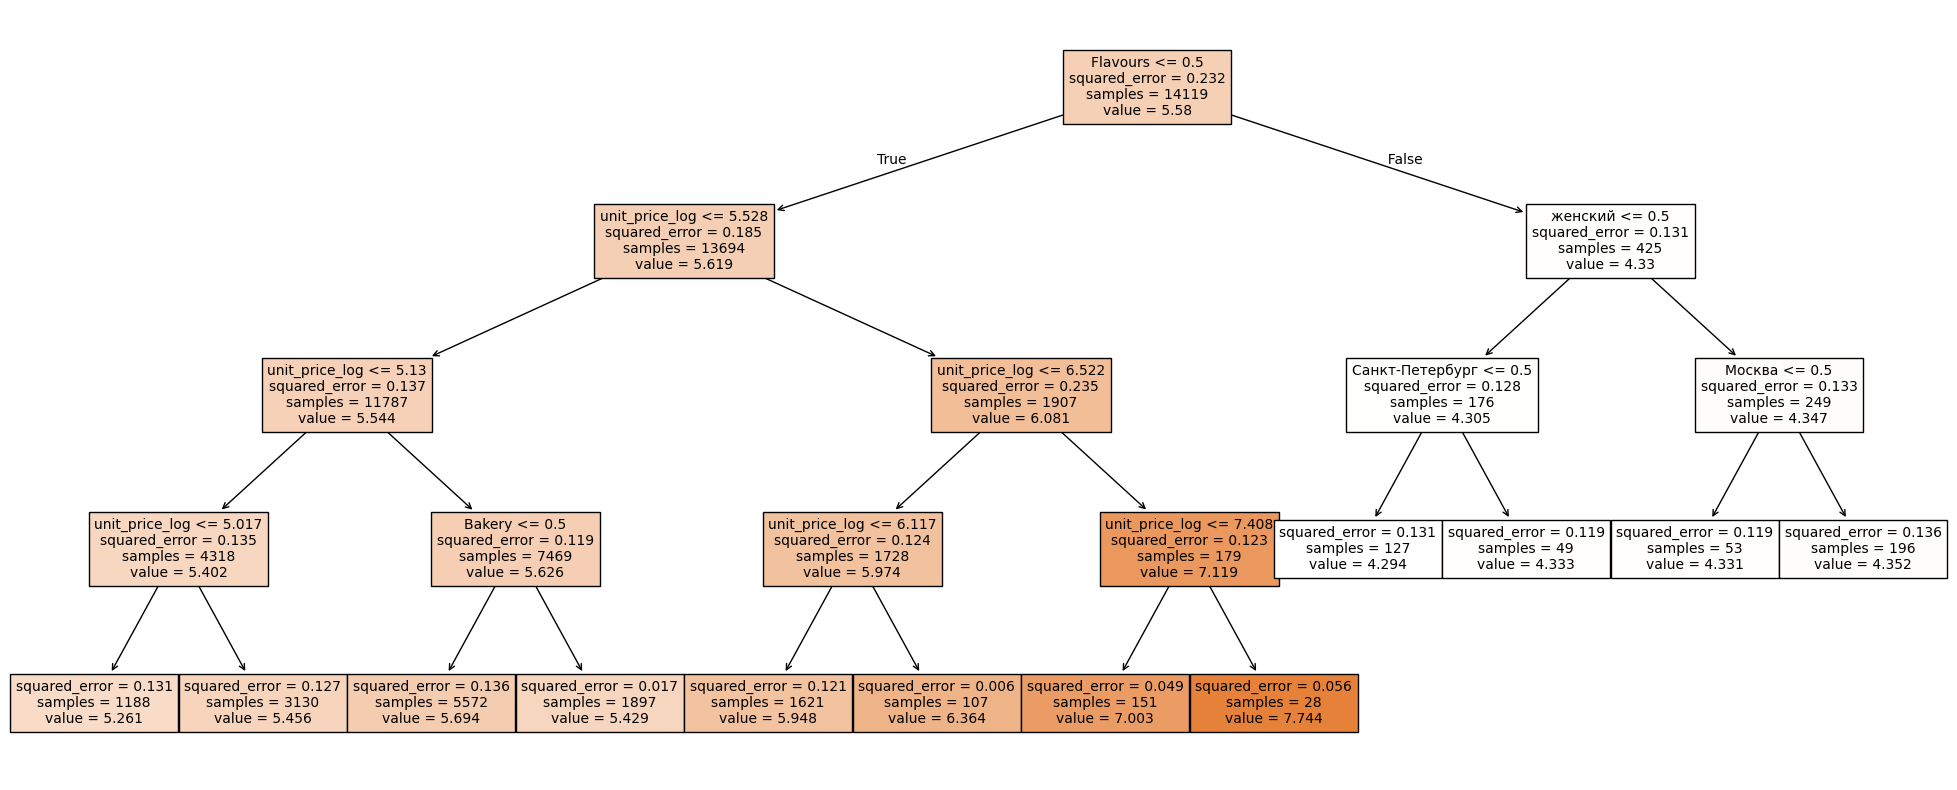

In [ ]:
plt.figure(figsize=(25,10))
tree.plot_tree(model3, feature_names=X_tree.columns, fontsize=10, filled=True)
plt.show()

# **Пример прогноза для нового клиента**

In [ ]:
new_customer = {
    'unit_price_log': np.log(200),
    'Coffee beans': 0,
    'Branded': 0,
    'Packaged Chocolate': 0,
    'Loose Tea': 0,
    'Bakery': 1,
    'Drinking Chocolate': 0,
    'Coffee': 0,
    'Tea': 0,
    'Flavours': 0,
    'Санкт-Петербург': 1,
    'Москва': 0,
    'мужской': 0,
    'женский': 1
}
new_customer_df = pd.DataFrame([new_customer])

In [ ]:
print("Признаки в new_customer_df:", new_customer_df.columns.tolist())

Признаки в new_customer_df: ['unit_price_log', 'Coffee beans', 'Branded', 'Packaged Chocolate', 'Loose Tea', 'Bakery', 'Drinking Chocolate', 'Coffee', 'Tea', 'Flavours', 'Санкт-Петербург', 'Москва', 'мужской', 'женский']


Дерево решений

In [ ]:
tree_pred = np.exp(model3.predict(new_customer_df))
Models.at['Forecast', 'Decision Tree'] = round(tree_pred[0], 2)
print(round(tree_pred[0], 2))

227.89


Вывод всех результатов

In [ ]:
print(Models)

           LinearRegressor  Polynomial Model  Decision Tree
R2 train          0.538085          0.538203       0.510904
R2 test           0.535046          0.534904       0.512360
MSE train     39434.839564      38554.659869   42589.373954
MSE test       9461.045903       9572.073368   11120.137755


# **Анализ переобучения/недообучения для дерева решений**

In [ ]:
DecisionTr = pd.DataFrame(index=QualityMetrics)

Переобученное дерево

In [ ]:
dtr_over = DecisionTreeRegressor(max_depth=50)
model_over = dtr_over.fit(np.array(X_tree_train['unit_price_log']).reshape(-1, 1), Y_tree_train)
Y_over_train_pred = model_over.predict(np.array(X_tree_train['unit_price_log']).reshape(-1, 1))
Y_over_test_pred = model_over.predict(np.array(X_tree_test['unit_price_log']).reshape(-1, 1))

DecisionTr['Overfitting'] = [
    r2_score(Y_tree_train, Y_over_train_pred),
    r2_score(Y_tree_test, Y_over_test_pred),
    mean_squared_error(np.exp(Y_tree_train), np.exp(Y_over_train_pred)),
    mean_squared_error(np.exp(Y_tree_test), np.exp(Y_over_test_pred))
]

Недообученное дерево

In [ ]:
dtr_under = DecisionTreeRegressor(max_depth=1)
model_under = dtr_under.fit(np.array(X_tree_train['unit_price_log']).reshape(-1, 1), Y_tree_train)
Y_under_train_pred = model_under.predict(np.array(X_tree_train['unit_price_log']).reshape(-1, 1))
Y_under_test_pred = model_under.predict(np.array(X_tree_test['unit_price_log']).reshape(-1, 1))

DecisionTr['Underfitting'] = [
    r2_score(Y_tree_train, Y_under_train_pred),
    r2_score(Y_tree_test, Y_under_test_pred),
    mean_squared_error(np.exp(Y_tree_train), np.exp(Y_under_train_pred)),
    mean_squared_error(np.exp(Y_tree_test), np.exp(Y_under_test_pred))
]

Оптимальное дерево

In [ ]:
dtr_good = DecisionTreeRegressor(max_depth=4)
model_good = dtr_good.fit(np.array(X_tree_train['unit_price_log']).reshape(-1, 1), Y_tree_train)
Y_good_train_pred = model_good.predict(np.array(X_tree_train['unit_price_log']).reshape(-1, 1))
Y_good_test_pred = model_good.predict(np.array(X_tree_test['unit_price_log']).reshape(-1, 1))

DecisionTr['Good fitting'] = [
    r2_score(Y_tree_train, Y_good_train_pred),
    r2_score(Y_tree_test, Y_good_test_pred),
    mean_squared_error(np.exp(Y_tree_train), np.exp(Y_good_train_pred)),
    mean_squared_error(np.exp(Y_tree_test), np.exp(Y_good_test_pred))
]

print(DecisionTr)

            Overfitting  Underfitting  Good fitting
R2 train       0.505428      0.201789      0.487614
R2 test        0.504540      0.219778      0.488526
MSE train  39540.078763  71098.644067  43203.944633
MSE test   10454.628058  29283.694338  11746.170742


Визуализация кривых обучения

In [ ]:
dots = np.linspace(X_tree_train['unit_price_log'].min(),
                   X_tree_train['unit_price_log'].max(),
                   1000).reshape(-1, 1)

Переобучение

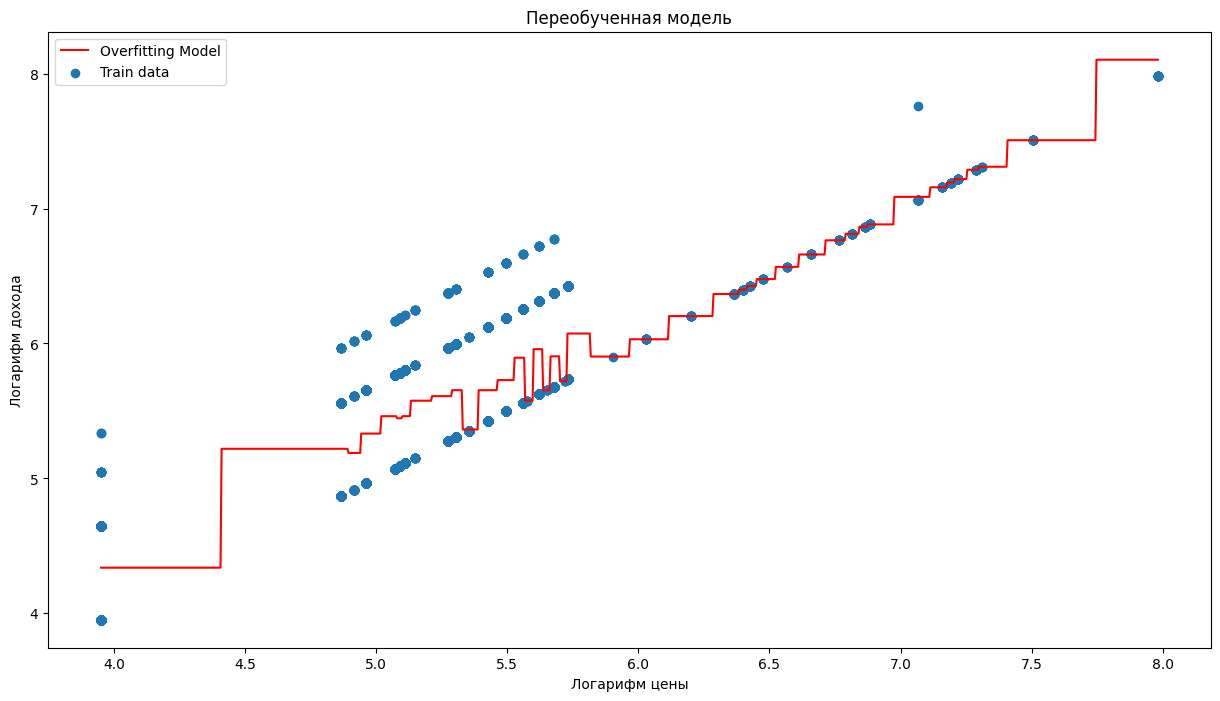

In [ ]:
pred_over = model_over.predict(dots)
plt.figure(figsize=(15, 8))
plt.plot(dots, pred_over, c='r', label='Overfitting Model')
plt.scatter(X_tree_train['unit_price_log'], Y_tree_train, label='Train data')
plt.title('Переобученная модель')
plt.xlabel('Логарифм цены')
plt.ylabel('Логарифм дохода')
plt.legend()
plt.show()

Недообучение

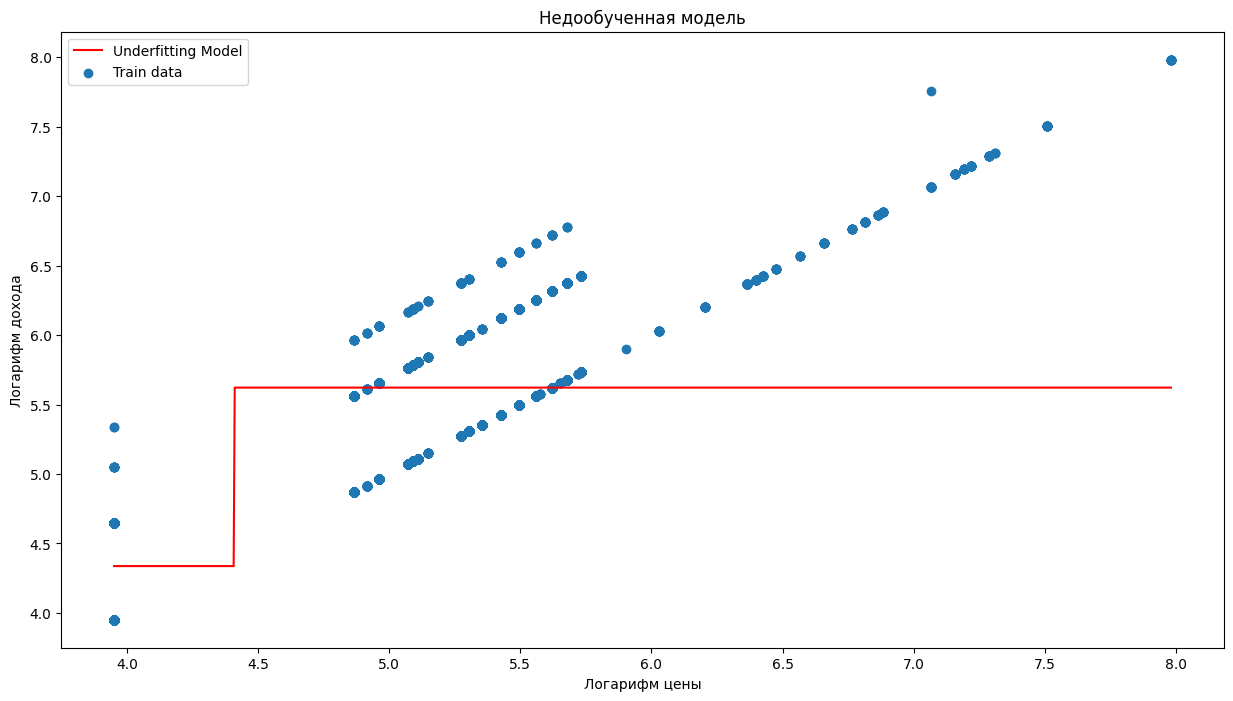

In [ ]:
pred_under = model_under.predict(dots)
plt.figure(figsize=(15, 8))
plt.plot(dots, pred_under, c='r', label='Underfitting Model')
plt.scatter(X_tree_train['unit_price_log'], Y_tree_train, label='Train data')
plt.title('Недообученная модель')
plt.xlabel('Логарифм цены')
plt.ylabel('Логарифм дохода')
plt.legend()
plt.show()

Оптимальная модель

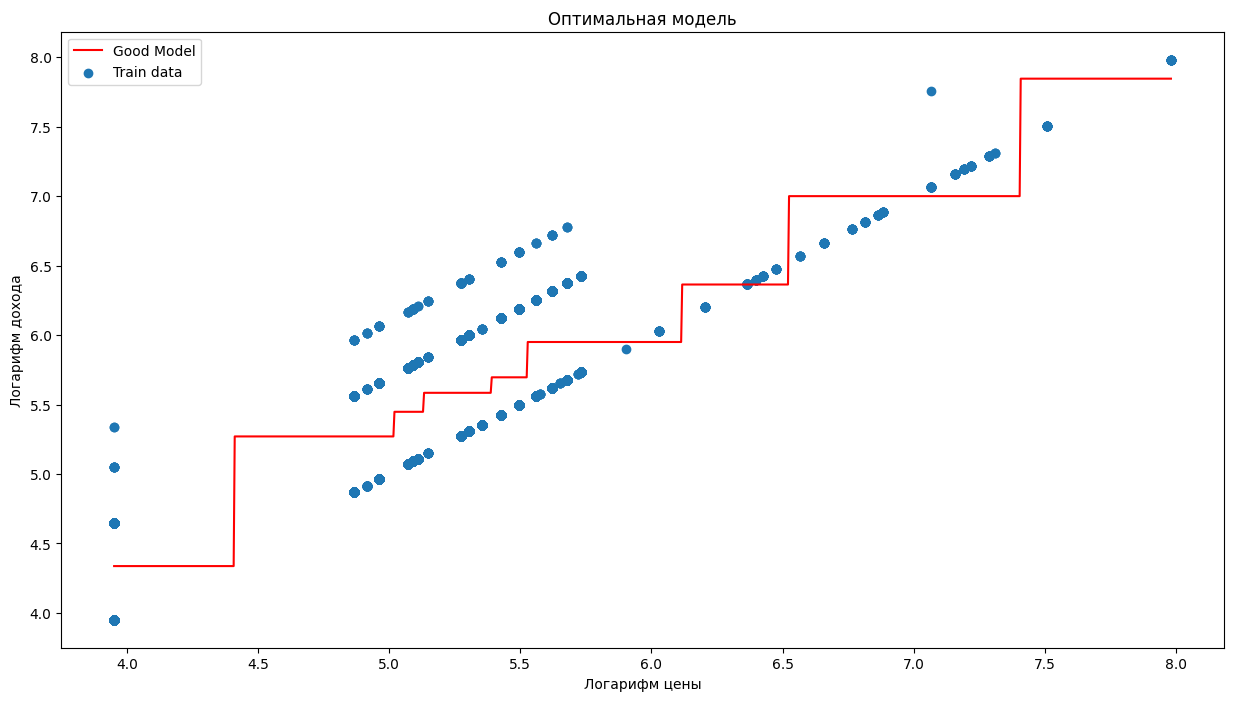

In [ ]:
pred_good = model_good.predict(dots)
plt.figure(figsize=(15, 8))
plt.plot(dots, pred_good, c='r', label='Good Model')
plt.scatter(X_tree_train['unit_price_log'], Y_tree_train, label='Train data')
plt.title('Оптимальная модель')
plt.xlabel('Логарифм цены')
plt.ylabel('Логарифм дохода')
plt.legend()
plt.show()